In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU available: {gpu_name}")
else:
    print("No GPU available.")

GPU available: Tesla T4


In [ ]:
IMAGE_SIZE=28
def show_data(sample):
  plt.imshow(sample[0].numpy().reshape((IMAGE_SIZE, IMAGE_SIZE)), cmap='gray')
  plt.title(str(sample[1]))

In [ ]:
composes = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True)])

In [ ]:
train_set = dset.MNIST(root='./data', train=True, transform=composes, download = True)
train_set

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
           )

In [ ]:
validation_set = dset.MNIST(root='./data', train=False, transform=composes, download = True)
validation_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
           )

In [ ]:
train_loader = DataLoader(train_set, batch_size=128,pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=5000)

In [ ]:
type(train_set[6][1])

int

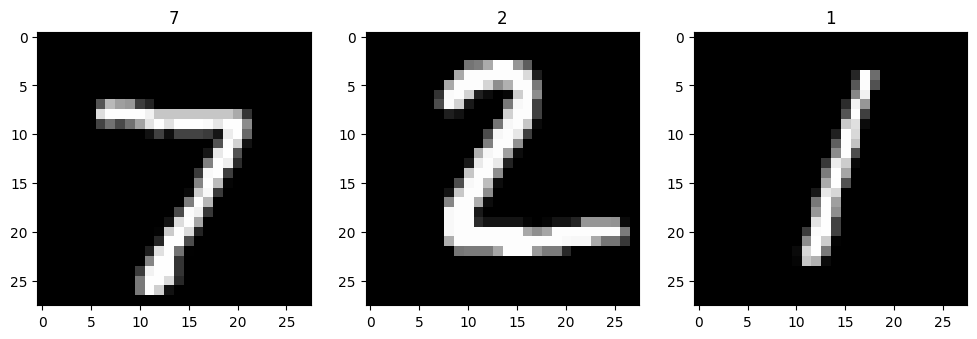

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    plt.sca(axes[i])
    show_data(validation_set[i])
plt.show()

## Output Size $= \frac{W-F + 2P}{s} + 1$

In [ ]:
class CNN(nn.Module):
  def __init__(self, out1, out2):
    super(CNN, self).__init__()

    self.cnn1 = nn.Conv2d(in_channels=1, out_channels= out1 ,kernel_size=5, padding=2)
    self.conv1_bn = nn.BatchNorm2d(out1)

    self.maxpool1 = nn.MaxPool2d(kernel_size=2)


    self.cnn2 = nn.Conv2d(in_channels= out1, out_channels=out2, kernel_size=5, stride=1, padding=2)
    self.conv2_bn = nn.BatchNorm2d(out2)

    self.maxpool2 = nn.MaxPool2d(kernel_size=2)


    self.fc1 = nn.Linear(out2*7*7, 10)
    self.fc1_bn = nn.BatchNorm1d(10)
  def forward(self, x):
    x = self.cnn1(x)
    x = self.conv1_bn(x)
    x = torch.relu(x)
    x = self.maxpool1(x)
    x = self.cnn2(x)
    x = self.conv2_bn(x)
    x = torch.relu(x)
    x = self.maxpool2(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    x = self.fc1_bn(x)
    return x

In [ ]:
model = CNN(32, 16).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)

In [ ]:
epochs = 10

In [ ]:
def plot_loss_and_accuracy(train_loss_list, validation_loss_list, accuracy_list):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [ ]:
def train_model(model, train_loader, validation_loader, optimizer, epochs):
    train_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    N_test = len(validation_loader.dataset)

    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to("cuda"), y.to("cuda")
            yhat_train = model(x)
            loss = criterion(yhat_train, y)
            loss.backward()
            optimizer.step()
            train_loss_list.append(loss.item())

        correct = 0
        with torch.no_grad():
            for x_cv, y_cv in validation_loader:
                model.eval()
                x_cv, y_cv = x_cv.to("cuda"), y_cv.to("cuda")
                yhat_validation = model(x_cv)
                _, yhat_max = torch.max(yhat_validation, 1)
                correct += (yhat_max == y_cv).sum().item()
            accuracy = correct / N_test
            accuracy_list.append(accuracy)
            print(f'Epoch: {epoch} ------ last loss item: {loss} ------ accuracy: {accuracy}')

    plot_loss_and_accuracy(train_loss_list, validation_loss_list, accuracy_list)


Epoch: 0 ------ last loss item: 0.1815941333770752 ------ accuracy: 0.9804
Epoch: 1 ------ last loss item: 0.25937288999557495 ------ accuracy: 0.9842
Epoch: 2 ------ last loss item: 0.20248223841190338 ------ accuracy: 0.9849
Epoch: 3 ------ last loss item: 0.2470637410879135 ------ accuracy: 0.9834
Epoch: 4 ------ last loss item: 0.23836062848567963 ------ accuracy: 0.986
Epoch: 5 ------ last loss item: 0.21506641805171967 ------ accuracy: 0.985
Epoch: 6 ------ last loss item: 0.22444598376750946 ------ accuracy: 0.9863
Epoch: 7 ------ last loss item: 0.23409658670425415 ------ accuracy: 0.9862
Epoch: 8 ------ last loss item: 0.2097608894109726 ------ accuracy: 0.9869
Epoch: 9 ------ last loss item: 0.14988668262958527 ------ accuracy: 0.9861


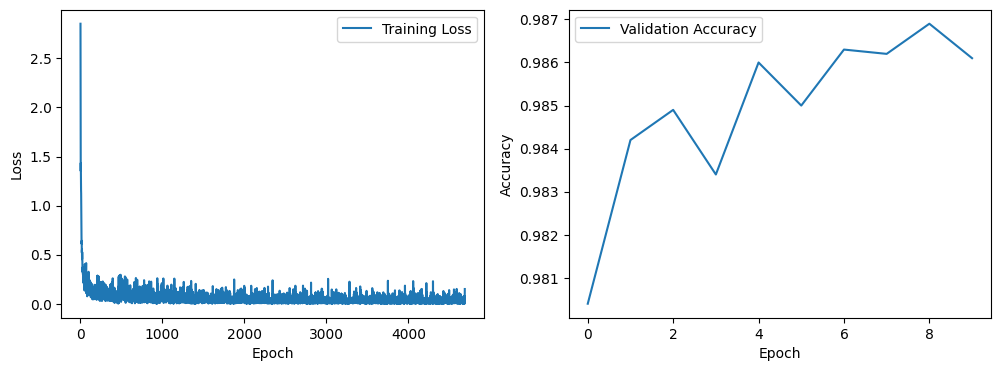

In [ ]:
train_model(model, train_loader, validation_loader, optimizer, epochs)

In [ ]:
class CNN2(nn.Module):
    def __init__(self, out1, out2):
        super(CNN2, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out1, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(out1)
        self.cnn2 = nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(out2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out2 * 7 * 7, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
model2 = CNN2(32, 64).to("cuda")

In [ ]:
optimizer = optim.Adam(model2.parameters(), lr = 0.1)
criterion = nn.CrossEntropyLoss()

Epoch: 0 ------ last loss item: 0.28797104954719543 ------ accuracy: 0.9683
Epoch: 1 ------ last loss item: 0.21136432886123657 ------ accuracy: 0.9741
Epoch: 2 ------ last loss item: 0.24915756285190582 ------ accuracy: 0.9805
Epoch: 3 ------ last loss item: 0.19875864684581757 ------ accuracy: 0.9836
Epoch: 4 ------ last loss item: 0.13325005769729614 ------ accuracy: 0.9839
Epoch: 5 ------ last loss item: 0.17003624141216278 ------ accuracy: 0.9855
Epoch: 6 ------ last loss item: 0.22801481187343597 ------ accuracy: 0.9812
Epoch: 7 ------ last loss item: 0.13365861773490906 ------ accuracy: 0.9797
Epoch: 8 ------ last loss item: 0.12466686964035034 ------ accuracy: 0.9824
Epoch: 9 ------ last loss item: 0.23443035781383514 ------ accuracy: 0.9808


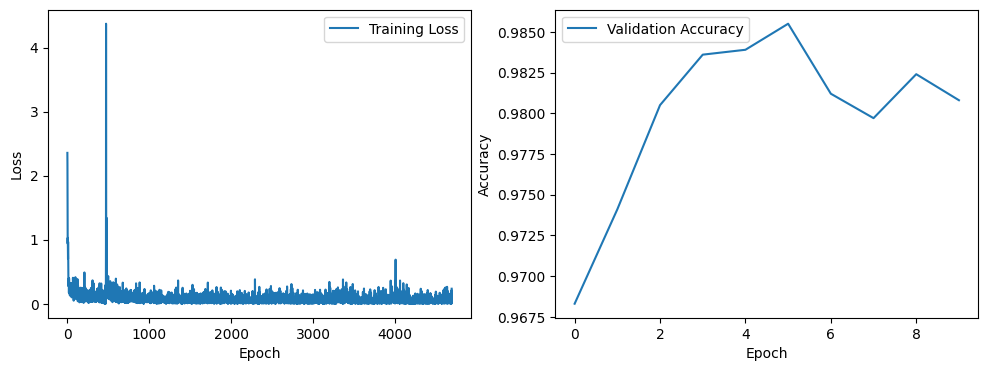

In [ ]:
train_model(model2, train_loader, validation_loader, optimizer, epochs)